## Barebone Numba implementation of Model Predictive Path Integral (MPPI) control proposed by Williams et al. [Paper link (see alg. 2).](https://ieeexplore.ieee.org/document/7989202)
* Unicycle dynamics
* Multiple obstacles

In [2]:
import numpy as np
import math
import copy
import numba
import time
from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_normal_float32


import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
import sys
sys.path.append('/home/yif/Documents/KTH/git/dynamicCageForMPPI/')
from pomp.bullet.forwardsimulator import *


In [2]:
# Information about your GPU
gpu = cuda.get_current_device()
print(gpu)
max_threads_per_block = gpu.MAX_THREADS_PER_BLOCK
max_square_block_dim = (int(gpu.MAX_BLOCK_DIM_X**0.5), int(gpu.MAX_BLOCK_DIM_X**0.5))
max_blocks = gpu.MAX_GRID_DIM_X
max_rec_blocks = rec_max_control_rollouts = int(1e6) # Though theoretically limited by max_blocks on GPU
rec_min_control_rollouts = 100

class Config:
  
  """ Configurations that are typically fixed throughout execution. """
  
  def __init__(self, 
               T=10, # Horizon (s)
               dt=0.1, # Length of each step (s)
               num_control_rollouts=1024, # Number of control sequences
               num_vis_state_rollouts=20, # Number of visualization rollouts
               seed=1):
    
    self.seed = seed
    self.T = T
    self.dt = dt
    self.num_steps = int(T/dt)
    self.max_threads_per_block = max_threads_per_block # save just in case

    assert T > 0
    assert dt > 0
    assert T > dt
    assert self.num_steps > 0
    
    # Number of control rollouts are currently limited by the number of blocks
    self.num_control_rollouts = num_control_rollouts
    if self.num_control_rollouts > rec_max_control_rollouts:
      self.num_control_rollouts = rec_max_control_rollouts
      print("MPPI Config: Clip num_control_rollouts to be recommended max number of {}. (Max={})".format(
        rec_max_control_rollouts, max_blocks))
    elif self.num_control_rollouts < rec_min_control_rollouts:
      self.num_control_rollouts = rec_min_control_rollouts
      print("MPPI Config: Clip num_control_rollouts to be recommended min number of {}. (Recommended max={})".format(
        rec_min_control_rollouts, rec_max_control_rollouts))
    
    # For visualizing state rollouts
    self.num_vis_state_rollouts = num_vis_state_rollouts
    self.num_vis_state_rollouts = min([self.num_vis_state_rollouts, self.num_control_rollouts])
    self.num_vis_state_rollouts = max([1, self.num_vis_state_rollouts])

<CUDA device 0 'b'NVIDIA GeForce RTX 3080 Laptop GPU''>


In [ ]:
DEFAULT_OBS_COST = 1e3
DEFAULT_DIST_WEIGHT = 10

# Stage costs (device function)
# @cuda.jit('float32(float32, float32)', device=True, inline=True)
def stage_cost(dist2, dist_weight):
  return dist_weight*dist2 # squared term makes the robot move faster

# Terminal costs (device function)
# @cuda.jit('float32(float32, boolean)', device=True, inline=True)
def term_cost(dist2, goal_reached):
  return (1-np.float32(goal_reached))*dist2

In [3]:
class MPPI_Numba(object):
  
  """ 
  Implementation of Information theoretic MPPI by Williams et. al. 
  Alg 2. in https://homes.cs.washington.edu/~bboots/files/InformationTheoreticMPC.pdf


  Planner object that initializes GPU memory and runs MPPI on GPU via numba. 
  
  Typical workflow: 
    1. Initialize object with config that allows pre-initialization of GPU memory
    2. reset()
    3. setup(mppi_params) based on problem instance
    4. solve(), which returns optimized control sequence
    5. get_state_rollout() for visualization
    6. shift_and_update(next_state, optimal_u_sequence, num_shifts=1)
    7. Repeat from 2 if params have changed
  """

  def __init__(self, cfg):

    # Fixed configs
    self.cfg = cfg
    self.T = cfg.T
    self.dt = cfg.dt
    self.num_steps = cfg.num_steps
    self.num_control_rollouts = cfg.num_control_rollouts

    self.num_vis_state_rollouts = cfg.num_vis_state_rollouts
    self.seed = cfg.seed

    # Basic info 
    self.max_threads_per_block = cfg.max_threads_per_block

    # Initialize reuseable device variables
    self.noise_samples_d = None
    self.u_cur_d = None
    self.u_prev_d = None
    self.costs_d = None
    self.weights_d = None
    self.rng_states_d = None
    self.state_rollout_batch_d = None # For visualization only. Otherwise, inefficient
    self.num_states = 10
    self.num_inputs = 4

    # Other task specific params
    self.device_var_initialized = False
    self.reset()

    
  def reset(self):
    # Other task specific params
    self.u_seq0 = np.zeros((self.num_steps, 4), dtype=np.float32)
    self.params = None
    self.params_set = False
    self.u_prev_d = None
    
    # Initialize all fixed-size device variables ahead of time. (Do not change in the lifetime of MPPI object)
    # self.init_device_vars_before_solving()
    # Initialize other necessary variables
    # self.noise_samples_d = np.zeros((self.num_control_rollouts, self.num_steps, 4), dtype=np.float32)
    self.noise_samples_d = cuda.device_array((self.num_control_rollouts, self.num_steps, self.num_inputs), dtype=np.float32) # to be sampled collaboratively via GPU
    self.u_cur_d = np.copy(self.u_seq0)
    self.u_prev_d = np.copy(self.u_seq0)
    self.costs_d = np.zeros((self.num_control_rollouts), dtype=np.float32)
    self.weights_d = np.zeros((self.num_control_rollouts), dtype=np.float32)
    self.state_rollout_batch_d = np.zeros((self.num_vis_state_rollouts, self.num_steps+1, self.num_states), dtype=np.float32)


  # def init_device_vars_before_solving(self):

  #   if not self.device_var_initialized:
  #     t0 = time.time()
      
  #     self.noise_samples_d = cuda.device_array((self.num_control_rollouts, self.num_steps, 4), dtype=np.float32) # to be sampled collaboratively via GPU
  #     self.u_cur_d = cuda.to_device(self.u_seq0) 
  #     self.u_prev_d = cuda.to_device(self.u_seq0) 
  #     self.costs_d = cuda.device_array((self.num_control_rollouts), dtype=np.float32)
  #     self.weights_d = cuda.device_array((self.num_control_rollouts), dtype=np.float32)
  #     self.rng_states_d = create_xoroshiro128p_states(self.num_control_rollouts*self.num_steps, seed=self.seed)
      
  #     self.state_rollout_batch_d = cuda.device_array((self.num_vis_state_rollouts, self.num_steps+1, 3), dtype=np.float32)
      
  #     self.device_var_initialized = True
  #     print("MPPI planner has initialized GPU memory after {} s".format(time.time()-t0))


  def setup(self, params):
    # These tend to change (e.g., current robot position, the map) after each step
    self.set_params(params)


  def set_params(self, params):
    self.params = copy.deepcopy(params)
    self.params_set = True


  def check_solve_conditions(self):
    if not self.params_set:
      print("MPPI parameters are not set. Cannot solve")
      return False
    if not self.device_var_initialized:
      print("Device variables not initialized. Cannot solve.")
      return False
    return True

  def solve(self):
    """Entry point for different algoritims"""
    
    if not self.check_solve_conditions():
      print("MPPI solve condition not met. Cannot solve. Return")
      return
    
    return self.solve_with_nominal_dynamics()


  def move_mppi_task_vars_to_device(self):
    # vrange_d = cuda.to_device(self.params['vrange'].astype(np.float32))
    # wrange_d = cuda.to_device(self.params['wrange'].astype(np.float32))
    # trange_d = cuda.to_device(self.params['trange'].astype(np.float32))
    # axrange_d = cuda.to_device(self.params['axrange'].astype(np.float32))
    # ayrange_d = cuda.to_device(self.params['ayrange'].astype(np.float32))
    # wrange_d = cuda.to_device(self.params['wrange'].astype(np.float32))
    # xgoal_d = cuda.to_device(self.params['xgoal'].astype(np.float32))

    trange_d = self.params['trange'].astype(np.float32)
    axrange_d = self.params['axrange'].astype(np.float32)
    ayrange_d = self.params['ayrange'].astype(np.float32)
    wrange_d = self.params['wrange'].astype(np.float32)
    xgoal_d = self.params['xgoal'].astype(np.float32)
    goal_tolerance_d = np.float32(self.params['goal_tolerance'])
    lambda_weight_d = np.float32(self.params['lambda_weight'])
    # u_std_d = cuda.to_device(self.params['u_std'].astype(np.float32))
    # x0_d = cuda.to_device(self.params['x0'].astype(np.float32))
    u_std_d = self.params['u_std'].astype(np.float32)
    x0_d = self.params['x0'].astype(np.float32)
    dt_d = np.float32(self.params['dt'])

    if "obstacle_positions" in self.params:
      # obs_pos_d = cuda.to_device(self.params['obstacle_positions'].astype(np.float32))
      obs_pos_d = self.params['obstacle_positions'].astype(np.float32)
    else:
      obs_pos_d = np.array([[1e5,1e5]], dtype=np.float32) # dummy value, else numba panics : (
    if "obstacle_radius" in self.params:
      obs_r_d = self.params['obstacle_radius'].astype(np.float32)
      # obs_r_d = cuda.to_device(self.params['obstacle_radius'].astype(np.float32))
    else:
      obs_r_d = np.array([0], dtype=np.float32) # dummy value, else numba panics : (

    obs_cost_d = np.float32(DEFAULT_OBS_COST if 'obs_penalty' not in self.params 
                                     else self.params['obs_penalty'])
    return trange_d, axrange_d, ayrange_d, wrange_d, xgoal_d, \
           goal_tolerance_d, lambda_weight_d, \
           u_std_d, x0_d, dt_d, obs_cost_d, obs_pos_d, obs_r_d


  def solve_with_nominal_dynamics(self):
    """
    Launch GPU kernels that use nominal dynamics but adjsuts cost function based on worst-case linear speed.
    """
    
    trange_d, axrange_d, ayrange_d, wrange_d, xgoal_d, goal_tolerance_d, lambda_weight_d, \
           u_std_d, x0_d, dt_d, obs_cost_d, obs_pos_d, obs_r_d = self.move_mppi_task_vars_to_device()
  
    # Weight for distance cost
    dist_weight = DEFAULT_DIST_WEIGHT if 'dist_weight' not in self.params else self.params['dist_weight']

    # Optimization loop
    for k in range(self.params['num_opt']):

      # Sample control noise
      self.sample_noise_numba[self.num_control_rollouts, self.num_steps](
            self.rng_states_d, u_std_d, self.noise_samples_d)
      
      # Rollout and compute mean or cvar
      self.rollout_numba[self.num_control_rollouts, 1](
        trange_d, 
        axrange_d, 
        ayrange_d,
        wrange_d,
        xgoal_d,
        obs_cost_d, 
        obs_pos_d, 
        obs_r_d,
        goal_tolerance_d,
        lambda_weight_d,
        u_std_d,
        x0_d,
        dt_d,
        dist_weight,
        self.noise_samples_d,
        self.u_cur_d,
        self.costs_d # results
      )
      self.u_prev_d = self.u_cur_d

      # Compute cost and update the optimal control on device
      self.update_useq_numba[1, 32](
        lambda_weight_d, 
        self.costs_d, 
        self.noise_samples_d, 
        self.weights_d, 
        trange_d, 
        axrange_d, 
        ayrange_d,
        wrange_d,
        self.u_cur_d # results
      )

    return self.u_cur_d.copy_to_host()


  def shift_and_update(self, new_x0, u_cur, num_shifts=1):
    self.params["x0"] = new_x0.copy()
    self.shift_optimal_control_sequence(u_cur, num_shifts)


  def shift_optimal_control_sequence(self, u_cur, num_shifts=1):
    u_cur_shifted = u_cur.copy()
    u_cur_shifted[:-num_shifts] = u_cur_shifted[num_shifts:]
    self.u_cur_d = cuda.to_device(u_cur_shifted.astype(np.float32))


  def get_state_rollout(self):
    """
    Generate state sequences based on the current optimal control sequence.
    """

    assert self.params_set, "MPPI parameters are not set"

    if not self.device_var_initialized:
      print("Device variables not initialized. Cannot run mppi.")
      return
    
    # Move things to GPU
    # trange_d = cuda.to_device(self.params['trange'].astype(np.float32))
    # axrange_d = cuda.to_device(self.params['axrange'].astype(np.float32))
    # ayrange_d = cuda.to_device(self.params['ayrange'].astype(np.float32))
    # wrange_d = cuda.to_device(self.params['wrange'].astype(np.float32))
    # x0_d = cuda.to_device(self.params['x0'].astype(np.float32))
    dt_d = np.float32(self.params['dt'])
    trange_d = self.params['trange'].astype(np.float32)
    axrange_d = self.params['axrange'].astype(np.float32)
    ayrange_d = self.params['ayrange'].astype(np.float32)
    wrange_d = self.params['wrange'].astype(np.float32)
    x0_d = self.params['x0'].astype(np.float32)

    self.get_state_rollout_across_control_noise[self.num_vis_state_rollouts, 1](
        self.state_rollout_batch_d, # where to store results
        x0_d, 
        dt_d,
        self.noise_samples_d,
        trange_d, 
        axrange_d, 
        ayrange_d,
        wrange_d,
        self.u_prev_d,
        self.u_cur_d,
        )
    
    return self.state_rollout_batch_d.copy_to_host()


  """GPU kernels from here on"""

  @staticmethod
  @cuda.jit(fastmath=True)
  def rollout_numba(
          trange_d, 
          axrange_d, 
          ayrange_d, 
          wrange_d, 
          xgoal_d, 
          obs_cost_d, 
          obs_pos_d, 
          obs_r_d,
          goal_tolerance_d, 
          lambda_weight_d, 
          u_std_d, 
          x0_d, 
          dt_d,
          dist_weight_d,
          noise_samples_d,
          u_cur_d,
          costs_d):
    """
    There should only be one thread running in each block, where each block handles a single sampled control sequence.
    """


    # Get block id and thread id
    bid = cuda.blockIdx.x   # index of block
    tid = cuda.threadIdx.x  # index of thread within a block
    costs_d[bid] = 0.0

    # Explicit unicycle update and map lookup
    # From here on we assume grid is properly padded so map lookup remains valid
    x_curr = cuda.local.array(10, numba.float32) # 10: num_states
    # for i in range(3): 
    for i in range(10): 
      x_curr[i] = x0_d[i]

    timesteps = len(u_cur_d)
    goal_reached = False
    goal_tolerance_d2 = goal_tolerance_d*goal_tolerance_d
    dist_to_goal2 = 1e9
    ax_nom = ax_noisy = ay_nom = ay_noisy = w_nom = w_noisy = 0.0

    # printed=False
    for t in range(timesteps):
      # Nominal noisy control
      # v_nom = u_cur_d[t, 0] + noise_samples_d[bid, t, 0]
      ax_nom = u_cur_d[t, 1] + noise_samples_d[bid, t, 1]
      ay_nom = u_cur_d[t, 2] + noise_samples_d[bid, t, 2]
      w_nom = u_cur_d[t, 3] + noise_samples_d[bid, t, 3]
      # v_noisy = max(vrange_d[0], min(vrange_d[1], v_nom))
      ax_noisy = max(axrange_d[0], min(axrange_d[1], ax_nom))
      ay_noisy = max(ayrange_d[0], min(ayrange_d[1], ay_nom))
      w_noisy = max(wrange_d[0], min(wrange_d[1], w_nom))
      
      # Forward simulate
      # x_curr[0] += dt_d*v_noisy*math.cos(x_curr[2])
      # x_curr[1] += dt_d*v_noisy*math.sin(x_curr[2])
      # x_curr[2] += dt_d*w_noisy
      # TODO
      # x_curr
      # u = [dt_d, ax_noisy, ay_noisy, w_noisy]
      # q, mu = self.toBulletStateInput(x, u)
      
      # q_curr = [x_curr[0],10-x_curr[1],
      #           x_curr[2],-x_curr[3],
      #           x_curr[4],10-x_curr[5],-x_curr[6],
      #           x_curr[7],-x_curr[8],-x_curr[9]]
      # mu_curr = [dt_d, ax_noisy, -ay_noisy, w_noisy]
      # self.dynamics_sim.reset_states(q)
      # q_new, qo_via_points = self.dynamics_sim.run_forward_sim(mu, print_via_points)
      # x_new = self.toOpenglStateInput(q_new)


      # If else statements will be expensive
      dist_to_goal2 = (xgoal_d[0]-x_curr[0])**2 + (xgoal_d[1]-x_curr[1])**2
      costs_d[bid]+= stage_cost(dist_to_goal2, dist_weight_d)

      # Add obstacle costs
      num_obs = len(obs_pos_d)
      for obs_i in range(num_obs):
        op = obs_pos_d[obs_i]
        dist_diff = (x_curr[0]-op[0])**2+(x_curr[1]-op[1])**2-obs_r_d[obs_i]**2
        costs_d[bid] += (1-numba.float32(dist_diff>0))*obs_cost_d

      if dist_to_goal2<= goal_tolerance_d2:
        goal_reached = True
        break
    
    # Accumulate terminal cost 
    costs_d[bid] += term_cost(dist_to_goal2, goal_reached)

    for t in range(timesteps):
      costs_d[bid] += lambda_weight_d*(
              (u_cur_d[t,0]/(u_std_d[0]**2))*noise_samples_d[bid, t,0] + (u_cur_d[t,1]/(u_std_d[1]**2))*noise_samples_d[bid, t, 1])

  @staticmethod
  @cuda.jit(fastmath=True)
  def update_useq_numba(
        lambda_weight_d,
        costs_d,
        noise_samples_d,
        weights_d,
        trange_d, 
        axrange_d, 
        ayrange_d,
        wrange_d,
        u_cur_d):
    """
    GPU kernel that updates the optimal control sequence based on previously evaluated cost values.
    Assume that the function is invoked as update_useq_numba[1, NUM_THREADS], with one block and multiple threads.
    """

    tid = cuda.threadIdx.x
    num_threads = cuda.blockDim.x
    numel = len(noise_samples_d)
    gap = int(math.ceil(numel / num_threads))

    # Find the minimum value via reduction
    starti = min(tid*gap, numel)
    endi = min(starti+gap, numel)
    if starti<numel:
      weights_d[starti] = costs_d[starti]
    for i in range(starti, endi):
      weights_d[starti] = min(weights_d[starti], costs_d[i])
    cuda.syncthreads()

    s = gap
    while s < numel:
      if (starti % (2 * s) == 0) and ((starti + s) < numel):
        # Stride by `s` and add
        weights_d[starti] = min(weights_d[starti], weights_d[starti + s])
      s *= 2
      cuda.syncthreads()

    beta = weights_d[0]
    
    # Compute weight
    for i in range(starti, endi):
      weights_d[i] = math.exp(-1./lambda_weight_d*(costs_d[i]-beta))
    cuda.syncthreads()

    # Normalize
    # Reuse costs_d array
    for i in range(starti, endi):
      costs_d[i] = weights_d[i]
    cuda.syncthreads()
    for i in range(starti+1, endi):
      costs_d[starti] += costs_d[i]
    cuda.syncthreads()
    s = gap
    while s < numel:
      if (starti % (2 * s) == 0) and ((starti + s) < numel):
        # Stride by `s` and add
        costs_d[starti] += costs_d[starti + s]
      s *= 2
      cuda.syncthreads()

    for i in range(starti, endi):
      weights_d[i] /= costs_d[0]
    cuda.syncthreads()
    
    # update the u_cur_d
    timesteps = len(u_cur_d)
    for t in range(timesteps):
      for i in range(starti, endi):
        cuda.atomic.add(u_cur_d, (t, 0), weights_d[i]*noise_samples_d[i, t, 0])
        cuda.atomic.add(u_cur_d, (t, 1), weights_d[i]*noise_samples_d[i, t, 1])
    cuda.syncthreads()

    # Blocks crop the control together
    tgap = int(math.ceil(timesteps / num_threads))
    starti = min(tid*tgap, timesteps)
    endi = min(starti+tgap, timesteps)
    for ti in range(starti, endi):
      u_cur_d[ti, 0] = max(vrange_d[0], min(vrange_d[1], u_cur_d[ti, 0]))
      u_cur_d[ti, 1] = max(wrange_d[0], min(wrange_d[1], u_cur_d[ti, 1]))


  @staticmethod
  @cuda.jit(fastmath=True)
  def get_state_rollout_across_control_noise(
          state_rollout_batch_d, # where to store results
          x0_d, 
          dt_d,
          noise_samples_d,
          trange_d, 
          axrange_d, 
          ayrange_d,
          wrange_d,
          u_prev_d,
          u_cur_d):
    """
    Do a fixed number of rollouts for visualization across blocks.
    Assume kernel is launched as get_state_rollout_across_control_noise[num_blocks, 1]
    The block with id 0 will always visualize the best control sequence. Other blocks will visualize random samples.
    """
    
    # Use block id
    tid = cuda.threadIdx.x
    bid = cuda.blockIdx.x
    timesteps = len(u_cur_d)


    if bid==0:
      # Visualize the current best 
      # Explicit unicycle update and map lookup
      # From here on we assume grid is properly padded so map lookup remains valid
      x_curr = cuda.local.array(3, numba.float32)
      for i in range(3): 
        x_curr[i] = x0_d[i]
        state_rollout_batch_d[bid,0,i] = x0_d[i]
      
      for t in range(timesteps):
        # Nominal noisy control
        v_nom = u_cur_d[t, 0]
        w_nom = u_cur_d[t, 1]
        
        # Forward simulate TODO
        x_curr[0] += dt_d*v_nom*math.cos(x_curr[2])
        x_curr[1] += dt_d*v_nom*math.sin(x_curr[2])
        x_curr[2] += dt_d*w_nom

        # Save state
        state_rollout_batch_d[bid,t+1,0] = x_curr[0]
        state_rollout_batch_d[bid,t+1,1] = x_curr[1]
        state_rollout_batch_d[bid,t+1,2] = x_curr[2]
    else:
      
      # Explicit unicycle update and map lookup
      # From here on we assume grid is properly padded so map lookup remains valid
      x_curr = cuda.local.array(3, numba.float32)
      for i in range(3): 
        x_curr[i] = x0_d[i]
        state_rollout_batch_d[bid,0,i] = x0_d[i]

      
      for t in range(timesteps):
        # Nominal noisy control
        v_nom = u_prev_d[t, 0] + noise_samples_d[bid, t, 0]
        w_nom = u_prev_d[t, 1] + noise_samples_d[bid, t, 1]
        v_noisy = max(vrange_d[0], min(vrange_d[1], v_nom))
        w_noisy = max(wrange_d[0], min(wrange_d[1], w_nom))

        # # Nominal noisy control
        v_nom = u_prev_d[t, 0]
        w_nom = u_prev_d[t, 1]
        
        # Forward simulate
        x_curr[0] += dt_d*v_noisy*math.cos(x_curr[2])
        x_curr[1] += dt_d*v_noisy*math.sin(x_curr[2])
        x_curr[2] += dt_d*w_noisy

        # Save state TODO
        state_rollout_batch_d[bid,t+1,0] = x_curr[0]
        state_rollout_batch_d[bid,t+1,1] = x_curr[1]
        state_rollout_batch_d[bid,t+1,2] = x_curr[2]


  @staticmethod
  @cuda.jit(fastmath=True)
  def sample_noise_numba(rng_states, u_std_d, noise_samples_d):
    """
    Should be invoked as sample_noise_numba[NUM_U_SAMPLES, NUM_THREADS].
    noise_samples_d.shape is assumed to be (num_rollouts, time_steps, 4)
    Assume each thread corresponds to one time step
    For consistency, each block samples a sequence, and threads (not too many) work together over num_steps.
    This will not work if time steps are more than max_threads_per_block (usually 1024)
    """
    block_id = cuda.blockIdx.x
    thread_id = cuda.threadIdx.x
    abs_thread_id = cuda.grid(1)

    noise_samples_d[block_id, thread_id, 0] = u_std_d[0]*xoroshiro128p_normal_float32(rng_states, abs_thread_id)
    noise_samples_d[block_id, thread_id, 1] = u_std_d[1]*xoroshiro128p_normal_float32(rng_states, abs_thread_id)
    noise_samples_d[block_id, thread_id, 2] = u_std_d[2]*xoroshiro128p_normal_float32(rng_states, abs_thread_id)
    noise_samples_d[block_id, thread_id, 3] = u_std_d[3]*xoroshiro128p_normal_float32(rng_states, abs_thread_id)

## Simple manipulation task

In [7]:
cfg = Config(T = 5.0,
            dt = 0.1,
            num_control_rollouts = int(1e3), # Same as number of blocks, can be more than 1024
            num_vis_state_rollouts = 20,
            seed = 1)

# x0 = np.array([0,0,np.pi/4])
# xgoal = np.array([7,5])
yo_init = 3
yo_goal = 6
half_extents_gripper = [.5, .1] # movement on x-z plane
radius_object = 0.01
x0 = np.array([2,yo_init,0,0,2,yo_init+radius_object+half_extents_gripper[1],0,0,0,0])
xgoal = np.array([5,yo_goal,0,0,0,0,0,0,0,0])
gravity = 9.81
# obstacle_positions = np.array([[5,4.5], [2,2.5]])
# obstacle_radius = np.array([1.5, 1])
obstacle_positions = np.array([])
obstacle_radius = np.array([])
assert len(obstacle_positions)==len(obstacle_radius)


mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0, # Start state
    xgoal=xgoal, # Goal position

    # For risk-aware min time planning
    goal_tolerance=0.5,
    dist_weight=10, #  Weight for dist-to-goal cost.

    lambda_weight=1.0, # Temperature param in MPPI
    num_opt=1, # Number of steps in each solve() function call.

    # Control and sample specification
    u_std=np.array([1.0, 1.0, 1.0, 1.0]), # Noise std for sampling linear and angular velocities.
    trange = np.array([0.0, 1.0]), # time range
    axrange = np.array([-0.3, 0.3]), # Linear acc range.
    ayrange = np.array([-gravity-5.0, -gravity+1.0]), # Linear acc range.
    wrange=np.array([-np.pi/27, np.pi/27]), # Angular acc range.

    ## obstacles
    obstacle_positions=obstacle_positions,
    obstacle_radius=obstacle_radius,
    obs_penalty=1e6,
)

In [8]:
# How fast does the loop run?
mppi_planner = MPPI_Numba(cfg)
mppi_planner.setup(mppi_params)

%timeit -n 5 -r 5 mppi_planner.solve()

MPPI planner has initialized GPU memory after 0.02195596694946289 s
2.02 ms ± 61.7 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


MPPI planner has initialized GPU memory after 0.00883936882019043 s


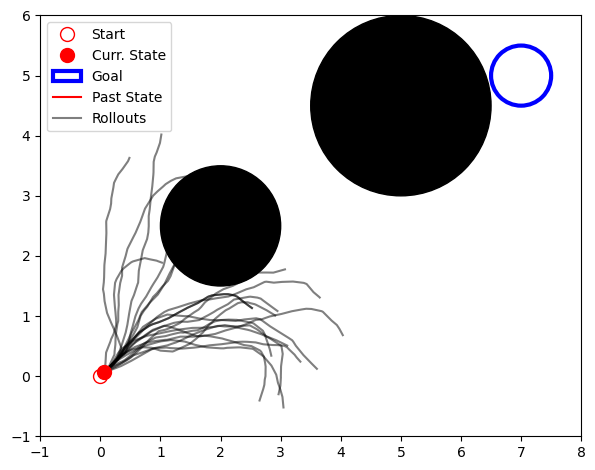

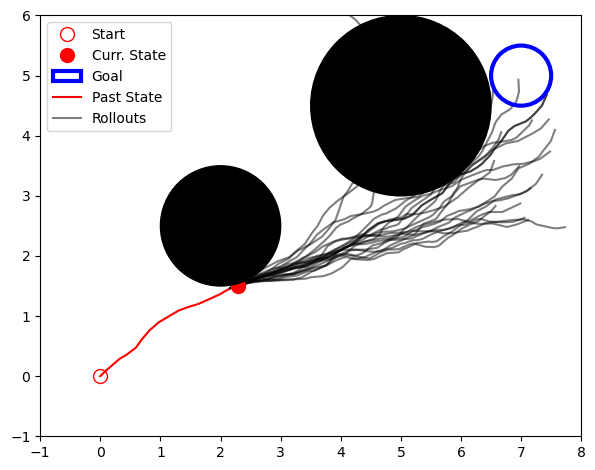

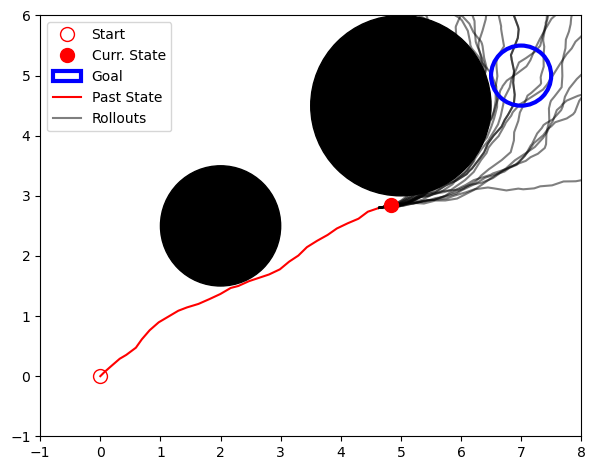

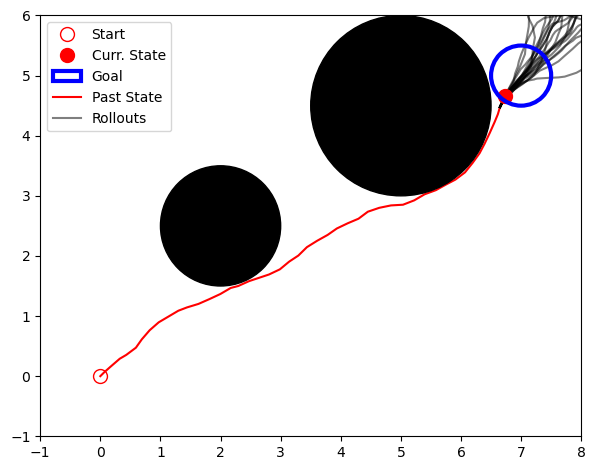

goal reached at t=4.50s


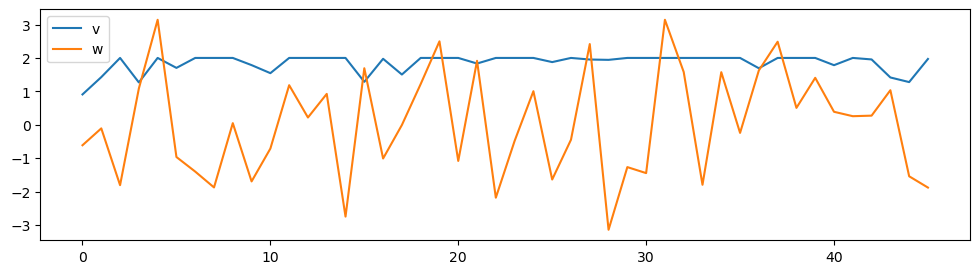

In [9]:
mppi_planner = MPPI_Numba(cfg)
mppi_planner.setup(mppi_params)

# Loop
max_steps = 151
xhist = np.zeros((max_steps+1, 3))*np.nan
uhist = np.zeros((max_steps, 2))*np.nan
xhist[0] = x0

vis_xlim = [0, 10]
vis_ylim = [0, 10]

plot_every_n = 15
for t in range(max_steps):
  # Solve
  useq = mppi_planner.solve()
  u_curr = useq[0]
  uhist[t] = u_curr

  # Simulate state forward using the sampled map. TODO
  xhist[t+1, 0] = xhist[t, 0] + cfg.dt*np.cos(xhist[t, 2])*u_curr[0]
  xhist[t+1, 1] = xhist[t, 1] + cfg.dt*np.sin(xhist[t, 2])*u_curr[0]
  xhist[t+1, 2] = xhist[t, 2] + cfg.dt*u_curr[1]

  if t%plot_every_n==0:
    # Visualize the basic set up
    fig, ax = plt.subplots()
    ax.plot([x0[0]], [x0[1]], 'ro', markersize=10, markerfacecolor='none', label="Start")
    ax.plot([xhist[t+1, 0]], [xhist[t+1, 1]], 'ro', markersize=10, label="Curr. State", zorder=5)
    c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='b', linewidth=3, fill=False, label="Goal", zorder=7)
    ax.add_patch(c1)

    # Show obstacles
    for obs_pos, obs_r in zip(obstacle_positions, obstacle_radius):
      obs = plt.Circle(obs_pos, obs_r, color='k', fill=True, zorder=6)
      ax.add_patch(obs)


    # Get rollout states from subset of maps for visualization? (e.g., 50)
    rollout_states_vis = mppi_planner.get_state_rollout()
    
    ax.plot(xhist[:,0], xhist[:,1], 'r', label="Past State")
    # ax.plot(rollout_states_vis[:,-1,0].T, rollout_states_vis[:,-1,1].T, 'r.', zorder=4)
    ax.plot(rollout_states_vis[:,:,0].T, rollout_states_vis[:,:,1].T, 'k', alpha=0.5, zorder=3)
    ax.plot(rollout_states_vis[0,:,0], rollout_states_vis[0,:,1], 'k', alpha=0.5, label="Rollouts")
    ax.set_xlim(vis_xlim)
    ax.set_ylim(vis_ylim)

    ax.legend(loc="upper left")
    ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()
  
  # Update MPPI state (x0, useq)
  mppi_planner.shift_and_update(xhist[t+1], useq, num_shifts=1)

  # Goal check
  if np.linalg.norm(xhist[t+1, :2] - mppi_params['xgoal']) <=mppi_params['goal_tolerance']:
    print("goal reached at t={:.2f}s".format(t*cfg.dt))
    break

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(uhist[:,0], label='v')
ax.plot(uhist[:,1], label='w')
ax.legend()
plt.show()